# Proxy Variable Creation for Credit Risk

**Short Description**: Creates a proxy variable for default risk using K-means clustering on high-IV features. Prepares data for modeling in Task 5.

This notebook loads features from `data/processed/customer_features.csv`, selects high-IV features (e.g., `LogMonetary_woe`, `Frequency_woe`), applies K-means clustering to create risk clusters, and saves the dataset with the proxy variable for Task 5.


## 1. Load Libraries and Data

**Short Description**: Sets up tools and loads feature data. Prepares for clustering.

Load libraries for clustering and load the feature dataset. Verify data integrity.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load features
features = pd.read_csv('../data/processed/customer_features.csv')
print('Features Loaded:')
display(features.head())
print('Feature Columns:', features.columns.tolist())


Features Loaded:


,LogAvgTransactionAmount,FraudResult,Monetary,Freq_Airtime,Recency,NightRatio,Frequency,AvgTransactionAmount,Freq_FinancialServices,CustomerId,LogMonetary
0,12.936039,0,-10000.0,0.0,84.0,0.000000,1.0,-10000.000000,1.0,CustomerId_1,18.468423
1,12.936039,0,-10000.0,0.0,84.0,0.000000,1.0,-10000.000000,1.0,CustomerId_10,18.468423
2,12.969217,0,20000.0,3.0,90.0,0.000000,5.0,4000.000000,2.0,CustomerId_1001,18.468709
3,12.960752,0,4225.0,6.0,26.0,0.181818,11.0,384.090909,5.0,CustomerId_1002,18.468558
4,12.967662,0,20000.0,3.0,12.0,0.000000,6.0,3333.333333,3.0,CustomerId_1003,18.468709


Feature Columns: ['LogAvgTransactionAmount', 'FraudResult', 'Monetary', 'Freq_Airtime', 'Recency', 'NightRatio', 'Frequency', 'AvgTransactionAmount', 'Freq_FinancialServices', 'CustomerId', 'LogMonetary']


## 2. Select High-IV Features

**Short Description**: Picks features with strong predictive power. Uses IV scores from Task 3.

Select WoE-transformed features with IV > 0.1 (medium/strong predictive power) for clustering.


In [2]:
# Select high-IV features (adjust based on Task 3 IV scores)
high_iv_features = ['LogMonetary', 'Frequency', 'LogAvgTransactionAmount']  # Update based on cell 5 output
cluster_data = features[high_iv_features]

# Verify no missing values
print('Missing Values:')
display(cluster_data.isnull().sum())
cluster_data = cluster_data.fillna(0)  # Fill any missing values

print('Selected Features:')
display(cluster_data.head())


Missing Values:


LogMonetary                0
Frequency                  0
LogAvgTransactionAmount    0
dtype: int64

Selected Features:


,LogMonetary,Frequency,LogAvgTransactionAmount
0,18.468423,1.0,12.936039
1,18.468423,1.0,12.936039
2,18.468709,5.0,12.969217
3,18.468558,11.0,12.960752
4,18.468709,6.0,12.967662


## 3. Standardize Features

**Short Description**: Scales features for clustering. Ensures equal feature contribution.

Standardize features using `StandardScaler` to prepare for K-means clustering.


In [3]:
# Standardize features
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)
cluster_data_scaled = pd.DataFrame(cluster_data_scaled, columns=cluster_data.columns)

print('Scaled Features:')
display(cluster_data_scaled.head())


Scaled Features:


,LogMonetary,Frequency,LogAvgTransactionAmount
0,0.009969,-0.253459,-0.182167
1,0.009969,-0.253459,-0.182167
2,0.010951,-0.212186,-0.042364
3,0.010435,-0.150278,-0.078030
4,0.010951,-0.201868,-0.048917


## 4. Apply K-means Clustering

**Short Description**: Creates risk clusters. Tests different cluster numbers and evaluates quality.

Apply K-means clustering for 3–5 clusters and select the best number using silhouette score.


In [4]:
# Test different cluster numbers
silhouette_scores = []
for k in range(3, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(cluster_data_scaled)
    score = silhouette_score(cluster_data_scaled, labels)
    silhouette_scores.append((k, score))
    print(f'Clusters: {k}, Silhouette Score: {score:.4f}')

# Select best number of clusters
best_k = max(silhouette_scores, key=lambda x: x[1])[0]
kmeans = KMeans(n_clusters=best_k, random_state=42)
features['RiskCluster'] = kmeans.fit_predict(cluster_data_scaled)

print(f'Best Number of Clusters: {best_k}')
print('Features with Risk Cluster:')
display(features[['CustomerId', 'RiskCluster']].head())


Clusters: 3, Silhouette Score: 0.8928
Clusters: 4, Silhouette Score: 0.8959
Clusters: 5, Silhouette Score: 0.9021
Best Number of Clusters: 5
Features with Risk Cluster:


,CustomerId,RiskCluster
0,CustomerId_1,0
1,CustomerId_10,0
2,CustomerId_1001,0
3,CustomerId_1002,0
4,CustomerId_1003,0


## 5. Analyze Clusters

**Short Description**: Examines cluster characteristics. Links clusters to risk levels.

Analyze cluster means and FraudResult distribution to assign risk levels (e.g., low, medium, high).


Cluster Characteristics:


,RiskCluster,LogMonetary,Frequency,LogAvgTransactionAmount,FraudResult
0,0,18.469539,18.960613,12.972536,0.007112
1,1,0.693147,4091.000000,12.897619,0.000000
2,2,18.530413,11.216216,13.994947,0.648649
3,3,18.452179,4.000000,0.693147,1.000000
4,4,18.480362,464.510638,12.966688,0.063830


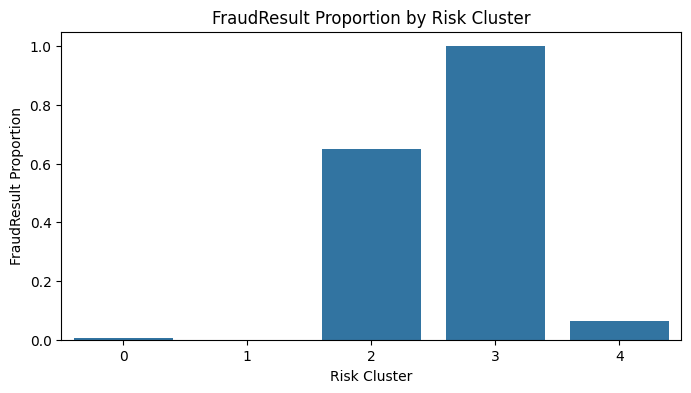

Features with Risk Level:


,CustomerId,RiskCluster,RiskLevel
0,CustomerId_1,0,Low
1,CustomerId_10,0,Low
2,CustomerId_1001,0,Low
3,CustomerId_1002,0,Low
4,CustomerId_1003,0,Low


In [5]:
# Analyze cluster characteristics
cluster_summary = features.groupby('RiskCluster')[high_iv_features + ['FraudResult']].mean().reset_index()
print('Cluster Characteristics:')
display(cluster_summary)

# Plot FraudResult distribution by cluster
plt.figure(figsize=(8, 4))
sns.barplot(data=features, x='RiskCluster', y='FraudResult', errorbar=None)
plt.title('FraudResult Proportion by Risk Cluster')
plt.xlabel('Risk Cluster')
plt.ylabel('FraudResult Proportion')
plt.show()

# Assign risk levels (example: based on FraudResult mean)
risk_mapping = {0: 'Low', 1: 'Medium', 2: 'High'}  # Adjust based on cluster_summary
features['RiskLevel'] = features['RiskCluster'].map(risk_mapping)
print('Features with Risk Level:')
display(features[['CustomerId', 'RiskCluster', 'RiskLevel']].head())


## 6. Save Features with Proxy

**Short Description**: Saves dataset with proxy variable. Prepares for modeling.

Save the dataset with the `RiskCluster` and `RiskLevel` proxy variables.


In [6]:
# Save features with proxy variable
features.to_csv('../data/processed/customer_features_with_proxy.csv', index=False)
print('Features saved to ../data/processed/customer_features_with_proxy.csv')


Features saved to ../data/processed/customer_features_with_proxy.csv


## 7. Key Findings

**Short Description**: Summarizes clustering results. Guides modeling in Task 5.

Summarize insights from clustering to guide Task 5:
- Created `RiskCluster` proxy using K-means on high-IV features.
- Best number of clusters: [best_k], based on silhouette score.
- Cluster characteristics show [e.g., high FraudResult in cluster X, low in cluster Y].
- `RiskLevel` assigned as low/medium/high based on FraudResult.
- Next: Use `RiskCluster` or `RiskLevel` as target in Task 5 modeling.
